In [1]:
import pyarrow.feather as feather
import pandas as pd
# 设置 Pandas 显示选项
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', 200)       # 设置显示宽度，防止换行
pd.set_option('display.max_rows', 20)      # 只显示 20 行数据（可根据需要调整）
# 文件路径
file_path = "/mnt/nvme2/yyc/medical-coding/files/data/mimiciii_50/mimiciii_50.feather"
# 读取 feather 文件
data = feather.read_table(file_path)
# 转换为 pandas DataFrame
df = data.to_pandas()
# 打印数据框
print(df)

       subject_id     _id      DESCRIPTION                                               text                                             cpt_id                                          icd9_diag  \
0               3  145834           Report  admission date discharge date date of birth se...                                     [94003, 94002]                      [428.0, 410.71, 038.9, 584.9]   
1               4  185777           Report  admission date discharge date date of birth se...                [99231, 99238, 99232, 99233, 99223]                                                 []   
2               6  107064           Report  admission date discharge date date of birth se...         [99231, 99239, 99291, 99232, 99233, 99255]                                    [285.9, V15.82]   
3               9  150750  Report+Addendum  admission date discharge date date of birth se...                                            [94003]                       [428.0, 401.9, 507.0, 584.9]   
4    

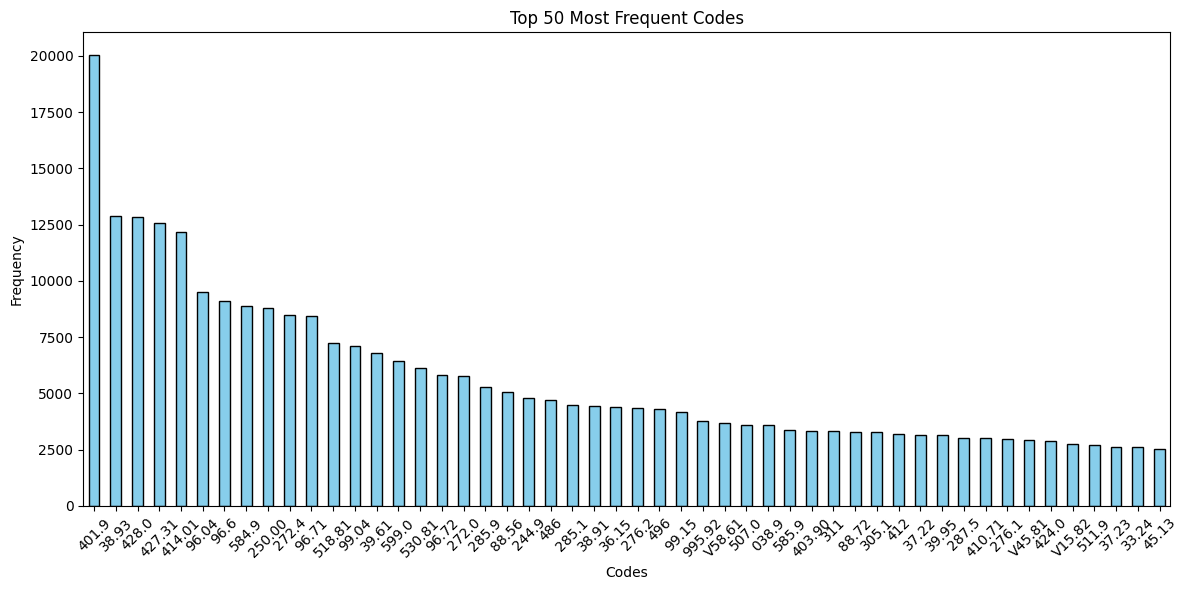

In [2]:
import matplotlib.pyplot as plt

icd9_diag = df['icd9_diag'].explode()  # 展开列表中的每个元素为独立行
icd9_proc = df['icd9_proc'].explode()  # 同上

# 合并所有编码列
all_codes = pd.concat([icd9_diag, icd9_proc])

# 统计出现频率
code_frequencies = all_codes.value_counts()

# 可视化前 50 个最常见的编码
top_20_codes = code_frequencies.head(50)

# 绘制柱状图
plt.figure(figsize=(12, 6))
top_20_codes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 50 Most Frequent Codes')
plt.xlabel('Codes')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

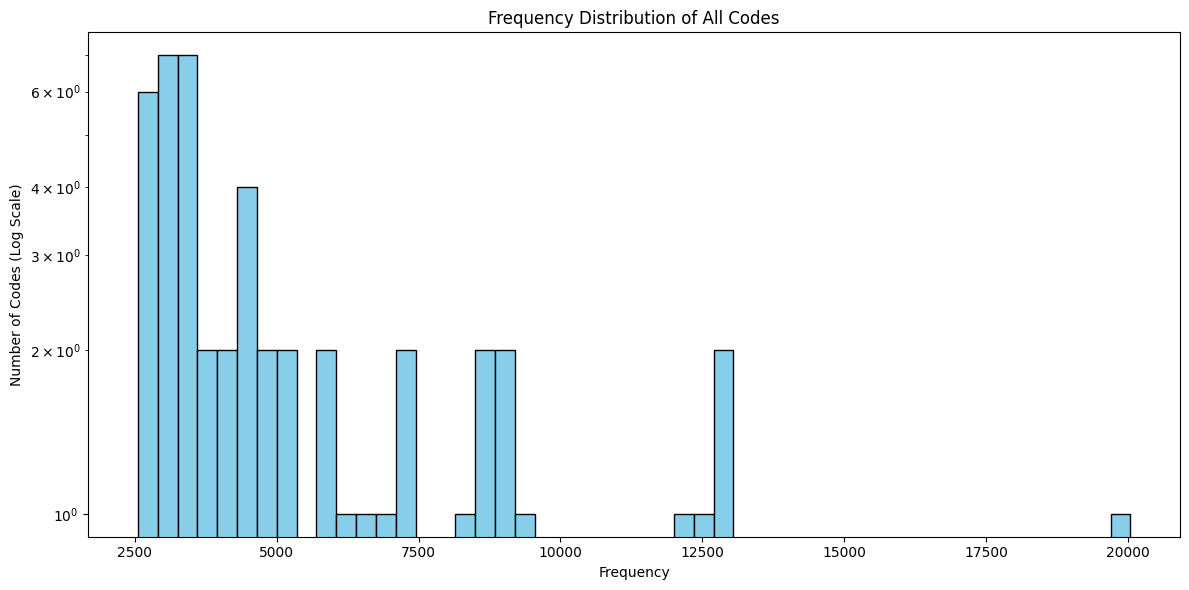

In [3]:
# 可视化所有编码的频率分布
plt.figure(figsize=(12, 6))
plt.hist(code_frequencies, bins=50, color='skyblue', edgecolor='black', log=True)
plt.title('Frequency Distribution of All Codes')
plt.xlabel('Frequency')
plt.ylabel('Number of Codes (Log Scale)')
plt.tight_layout()
plt.show()

In [4]:
# 定义函数计算每个样本中 target 编码的平均频率
def calculate_average_frequency(targets):
    frequencies = [code_frequencies[code] for code in targets if code in code_frequencies]
    return sum(frequencies) / len(frequencies) if frequencies else 0

df['avg_code_frequency'] = df['target'].apply(calculate_average_frequency)

# 加权平均频率，使低频编码的权重更高
def calculate_weighted_frequency(targets):
    frequencies = [code_frequencies[code] for code in targets if code in code_frequencies]
    if not frequencies:
        return 0
    # 计算加权平均频率，权重为 1/frequency
    weights = [1 / freq for freq in frequencies]
    weighted_sum = sum(freq * weight for freq, weight in zip(frequencies, weights))
    return weighted_sum / sum(weights)

df['weighted_avg_frequency'] = df['target'].apply(calculate_weighted_frequency)

#使用最低频率的编码
def calculate_min_frequency(targets):
    frequencies = [code_frequencies[code] for code in targets if code in code_frequencies]
    return min(frequencies) if frequencies else 0

df['min_code_frequency'] = df['target'].apply(calculate_min_frequency)
print(df)

       subject_id     _id      DESCRIPTION                                               text                                             cpt_id                                          icd9_diag  \
0               3  145834           Report  admission date discharge date date of birth se...                                     [94003, 94002]                      [428.0, 410.71, 038.9, 584.9]   
1               4  185777           Report  admission date discharge date date of birth se...                [99231, 99238, 99232, 99233, 99223]                                                 []   
2               6  107064           Report  admission date discharge date date of birth se...         [99231, 99239, 99291, 99232, 99233, 99255]                                    [285.9, V15.82]   
3               9  150750  Report+Addendum  admission date discharge date date of birth se...                                            [94003]                       [428.0, 401.9, 507.0, 584.9]   
4    

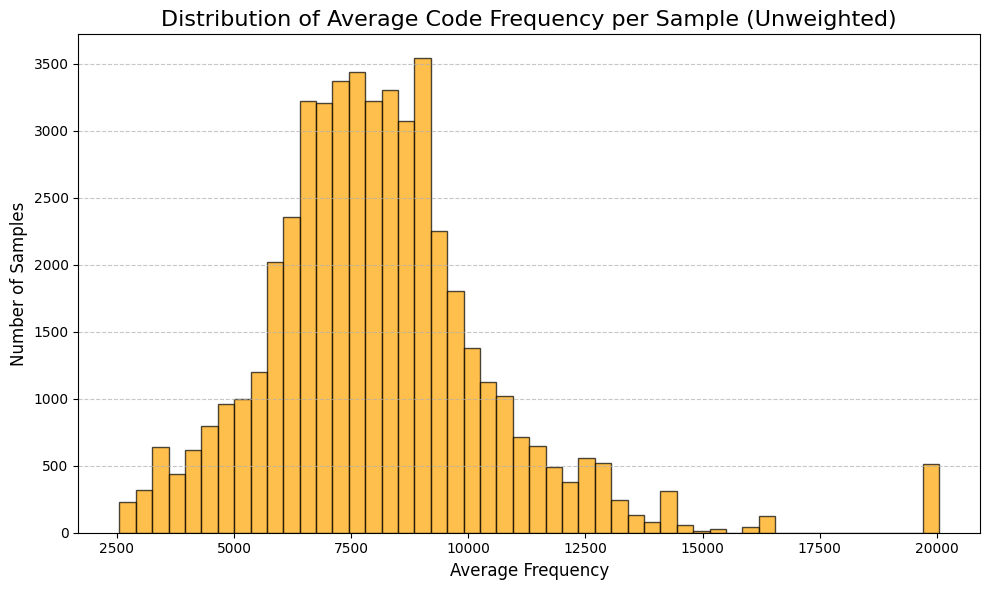

In [5]:
# 可视化不加权的平均频率分布
plt.figure(figsize=(10, 6))
plt.hist(df['avg_code_frequency'], bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Code Frequency per Sample (Unweighted)', fontsize=16)
plt.xlabel('Average Frequency', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

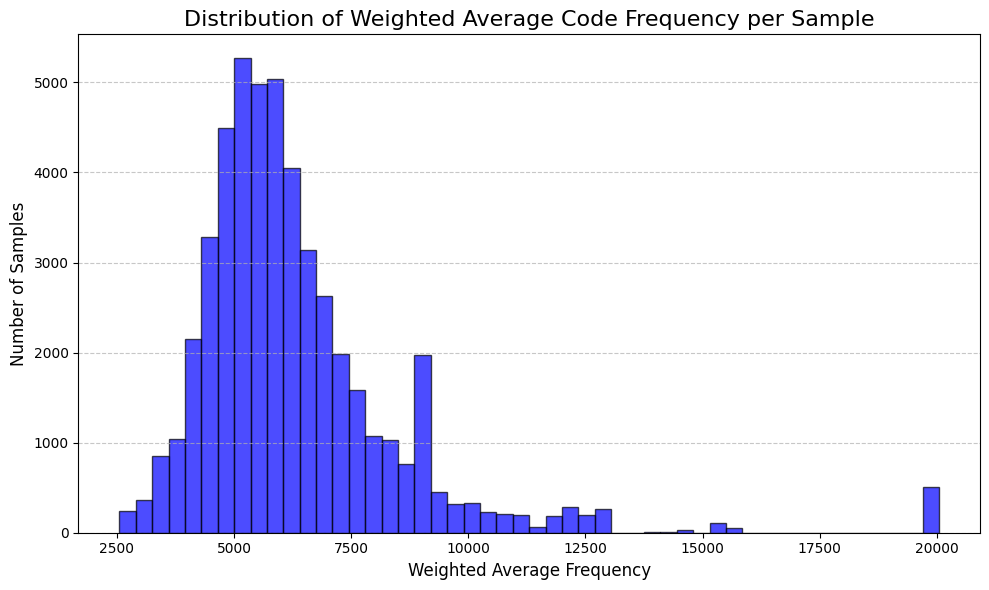

In [6]:
import numpy as np
# 加权平均频率分布
plt.figure(figsize=(10, 6))
plt.hist(df['weighted_avg_frequency'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Weighted Average Code Frequency per Sample', fontsize=16)
plt.xlabel('Weighted Average Frequency', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

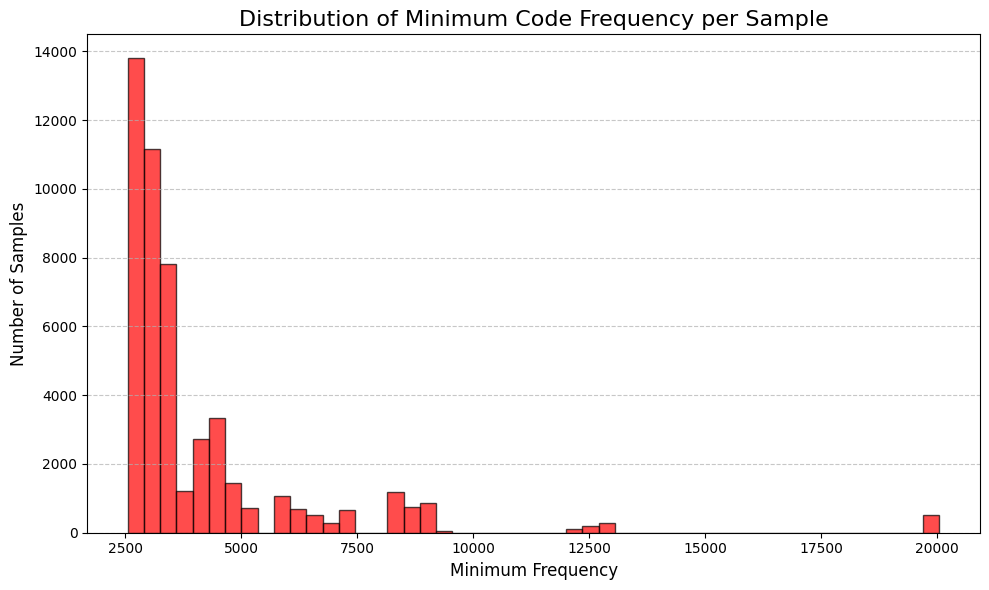

In [7]:
# 最低频率分布
plt.figure(figsize=(10, 6))
plt.hist(df['min_code_frequency'], bins=50, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribution of Minimum Code Frequency per Sample', fontsize=16)
plt.xlabel('Minimum Frequency', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
# 根据 'weighted_avg_frequency' 列进行划分
def assign_difficulty(row):
    if row['weighted_avg_frequency'] > 6000:
        return 'easy'
    elif 4000 <= row['weighted_avg_frequency'] <= 6000:
        return 'middle'
    else:
        return 'hard'

# 创建新的 'difficulty' 列
df['difficulty'] = df.apply(assign_difficulty, axis=1)
print(df)
# 保存为新文件
output_path = "/mnt/nvme2/yyc/medical-coding/files/data/mimiciii_50/mimiciii_50_difficulty_from_frequency.feather"
df.to_feather(output_path)

       subject_id     _id      DESCRIPTION                                               text                                             cpt_id                                          icd9_diag  \
0               3  145834           Report  admission date discharge date date of birth se...                                     [94003, 94002]                      [428.0, 410.71, 038.9, 584.9]   
1               4  185777           Report  admission date discharge date date of birth se...                [99231, 99238, 99232, 99233, 99223]                                                 []   
2               6  107064           Report  admission date discharge date date of birth se...         [99231, 99239, 99291, 99232, 99233, 99255]                                    [285.9, V15.82]   
3               9  150750  Report+Addendum  admission date discharge date date of birth se...                                            [94003]                       [428.0, 401.9, 507.0, 584.9]   
4    

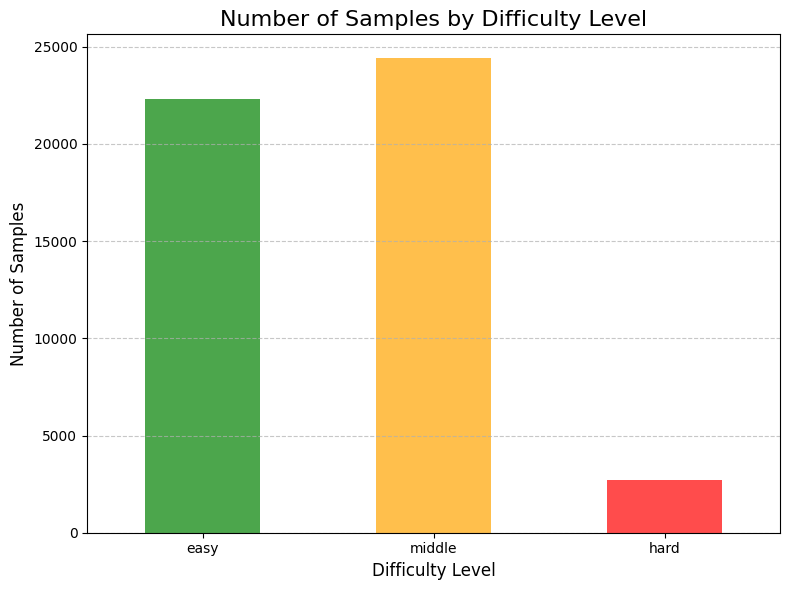

In [9]:
import matplotlib.pyplot as plt

# 确保按照 easy, middle, hard 的顺序排列
difficulty_order = ['easy', 'middle', 'hard']
difficulty_counts = df['difficulty'].value_counts().reindex(difficulty_order)

# 绘制柱状图可视化
plt.figure(figsize=(8, 6))
difficulty_counts.plot(kind='bar', color=['green', 'orange', 'red'], alpha=0.7)
plt.title('Number of Samples by Difficulty Level', fontsize=16)
plt.xlabel('Difficulty Level', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()